# XGBoost Model Calibration

This notebook contains cells extracted from `xgboost_evaluation.ipynb`, focusing on model calibration techniques and their evaluation.

In [2]:
import joblib
import json
import os

import numpy as np 
import xgboost as xgb 
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

import utils

In [3]:
df = utils.load_preprocessed_data('data/preprocessed_data2.parquet')

X_train_scaled, y_train, X_test_scaled, y_test = utils.split_data_features_target(df)

y_train = utils.convert_target_variable(y_train) 
y_test = utils.convert_target_variable(y_test)

Loading preprocessed data from data/preprocessed_data2.parquet...
Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 3700 entries, 0 to 739
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BIB           3700 non-null   float64
 1   FAN           3700 non-null   float64
 2   LUK           3700 non-null   float64
 3   NUS           3700 non-null   float64
 4   SIS           3700 non-null   float64
 5   UIN           3700 non-null   float64
 6   WET           3700 non-null   float64
 7   COD_iii       3700 non-null   float64
 8   COD_rrr       3700 non-null   float64
 9   COD_uuu       3700 non-null   float64
 10  ERG_aaa       3700 non-null   float64
 11  ERG_missing   3700 non-null   float64
 12  ERG_nnn       3700 non-null   float64
 13  ERG_www       3700 non-null   float64
 14  GJAH_ii       3700 non-null   float64
 15  GJAH_iii      3700 non-null   float64
 16  GJAH_missing  3700 non-null 

In [4]:
# Calculate class distribution in the training set for scale_pos_weight
scale_pos_weight_val = 1 # Default
if y_train.dtype == 'int64' or y_train.dtype == 'int32':
    count_class_0 = (y_train == 0).sum()
    count_class_1 = (y_train == 1).sum()
    print(f"\nTraining data class distribution: Class 0 (n): {count_class_0}, Class 1 (y): {count_class_1}")
    if count_class_1 > 0:
        scale_pos_weight_val = count_class_0 / count_class_1
        print(f"Calculated scale_pos_weight: {scale_pos_weight_val:.4f}")
    else:
        print("Warning: No positive class (1) instances in y_train. scale_pos_weight set to 1.")
else:
    print(f"Warning: y_train is not numeric (dtype: {y_train.dtype}). scale_pos_weight set to 1.")


Training data class distribution: Class 0 (n): 221, Class 1 (y): 2739
Calculated scale_pos_weight: 0.0807


In [5]:
# Define and Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False, # Recommended to avoid warnings
    random_state=42,
    n_estimators=100, # Default, can be tuned
    scale_pos_weight=scale_pos_weight_val
)

xgb_clf.fit(X_train_scaled, y_train)
print("Model training complete.")

n_splits_cv = 3 # Reduced for dummy example
strat_k_fold = StratifiedKFold(n_splits=n_splits_cv, shuffle=True, random_state=42)
scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1_weighted'
}

print("--- Placeholder variables defined ---")
print(f"X_train_scaled shape: {X_train_scaled.shape}, y_train shape: {y_train.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}, y_test shape: {y_test.shape}")
print(f"xgb_clf: {type(xgb_clf)}")
print(f"scale_pos_weight_val: {scale_pos_weight_val}")

Model training complete.
--- Placeholder variables defined ---
X_train_scaled shape: (2960, 53), y_train shape: (2960,)
X_test_scaled shape: (740, 53), y_test shape: (740,)
xgb_clf: <class 'xgboost.sklearn.XGBClassifier'>
scale_pos_weight_val: 0.08068638189120117


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:05:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Model Calibration Analysis

A calibration curve (also known as a reliability diagram) helps to assess how well the probabilistic predictions of a classifier are calibrated.
Ideally, if a model predicts a class with a probability of `p`, then among all instances where it predicts `p`, approximately `p * 100%` of them should actually belong to that class.
A perfectly calibrated model will have a curve that lies along the diagonal.


A bias in the training dataset, such as a skew in the class distribution, means that the model will naturally predict a higher probability for the majority class than the minority class on average.


--- Model Calibration Analysis ---


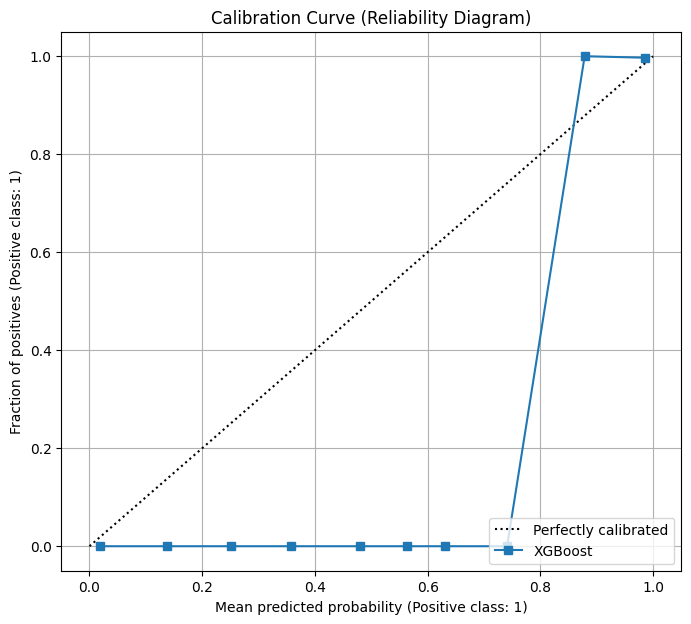

In [6]:
from sklearn.calibration import CalibrationDisplay


print("\n--- Model Calibration Analysis ---")


# Display calibration curve
plt.figure(figsize=(8, 7))
ax_calibration = plt.gca() # Get current axes
calibration_disp = CalibrationDisplay.from_estimator(
    xgb_clf,
    X_test_scaled,
    y_test,
    n_bins=10, # Number of bins to discretize the [0, 1] interval
    ax=ax_calibration,
    name='XGBoost'
)
plt.title('Calibration Curve (Reliability Diagram)')
plt.grid(True)
plt.show()

### Applying Platt Scaling (Sigmoid Calibration)


Since the initial calibration curve might not be perfectly diagonal, we can attempt to improve it using Platt Scaling. This method trains a logistic regression model on the outputs of the original XGBoost classifier to produce better-calibrated probabilities.


We will use `CalibratedClassifierCV` with `method='sigmoid'` to apply Platt Scaling. The calibrator will be trained using cross-validation on the training data.

### Applying Isotonic Regression Calibration


Isotonic Regression is another method to calibrate probabilities. Unlike Platt Scaling, which assumes a sigmoid relationship, Isotonic Regression is non-parametric and fits a non-decreasing function. It can be more powerful if the distortion is not sigmoid-shaped, but may require more data to avoid overfitting.


We will use `CalibratedClassifierCV` with `method='isotonic'`.

Fitting CalibratedClassifierCV with Platt Scaling...
Platt Scaling fitting complete.

Fitting CalibratedClassifierCV with Isotonic Regression...
Isotonic Regression fitting complete.

Plotting calibration curves...


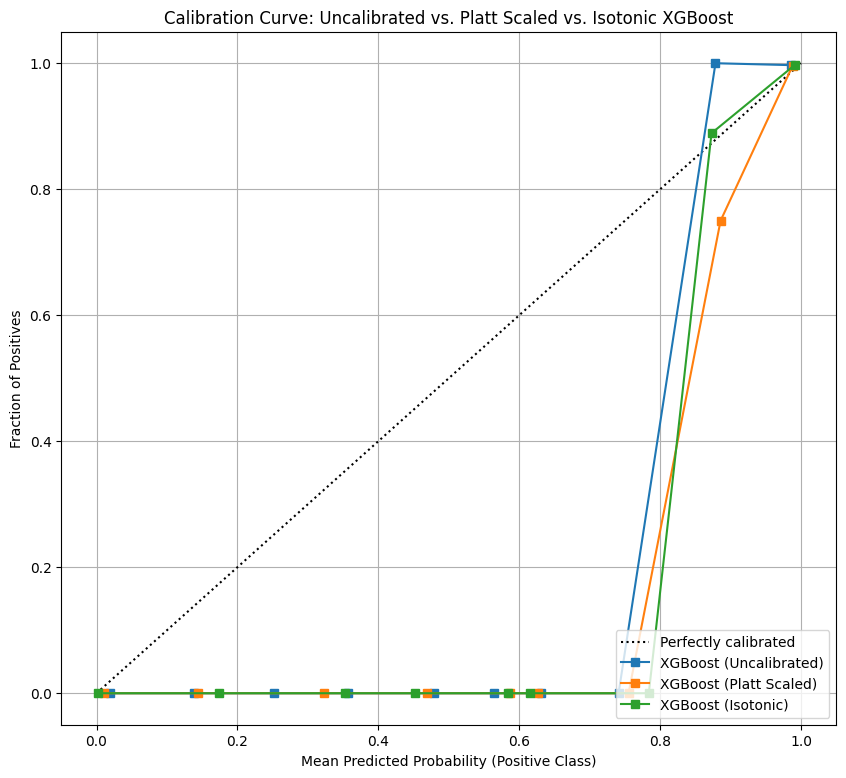

In [7]:
# --- Platt Scaling (Sigmoid) --- 
base_clf_for_sigmoid = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight_val
)
calibrated_xgb_clf_sigmoid = CalibratedClassifierCV(
    estimator=base_clf_for_sigmoid, 
    method='sigmoid', 
    cv=5
)
print("Fitting CalibratedClassifierCV with Platt Scaling...")
calibrated_xgb_clf_sigmoid.fit(X_train_scaled, y_train)
print("Platt Scaling fitting complete.")


# --- Isotonic Regression --- 
base_clf_for_isotonic = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight_val
)
calibrated_xgb_clf_isotonic = CalibratedClassifierCV(
    estimator=base_clf_for_isotonic, 
    method='isotonic', 
    cv=5 
)
print("\nFitting CalibratedClassifierCV with Isotonic Regression...")
calibrated_xgb_clf_isotonic.fit(X_train_scaled, y_train)
print("Isotonic Regression fitting complete.")


# --- Display comparative calibration curves --- 
plt.figure(figsize=(10, 9))
ax_calibrated = plt.gca()
print("\nPlotting calibration curves...")
CalibrationDisplay.from_estimator(
    xgb_clf, 
    X_test_scaled, 
    y_test, 
    ax=ax_calibrated, 
    name='XGBoost (Uncalibrated)', 
    n_bins=10
)
CalibrationDisplay.from_estimator(
    calibrated_xgb_clf_sigmoid, 
    X_test_scaled, 
    y_test, 
    ax=ax_calibrated, 
    name='XGBoost (Platt Scaled)',
    n_bins=10
)
CalibrationDisplay.from_estimator(
    calibrated_xgb_clf_isotonic, 
    X_test_scaled, 
    y_test, 
    ax=ax_calibrated, 
    name='XGBoost (Isotonic)',
    n_bins=10
)
plt.title('Calibration Curve: Uncalibrated vs. Platt Scaled vs. Isotonic XGBoost')
plt.xlabel('Mean Predicted Probability (Positive Class)')
plt.ylabel('Fraction of Positives')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()




--- Evaluating Platt Scaled Model ---

--- XGBoost (Platt Scaled) Evaluation ---
Accuracy: 0.9865

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.82      0.90        55
 Class y (1)       0.99      1.00      0.99       685

    accuracy                           0.99       740
   macro avg       0.99      0.91      0.95       740
weighted avg       0.99      0.99      0.99       740


Confusion Matrix:
[[ 45  10]
 [  0 685]]


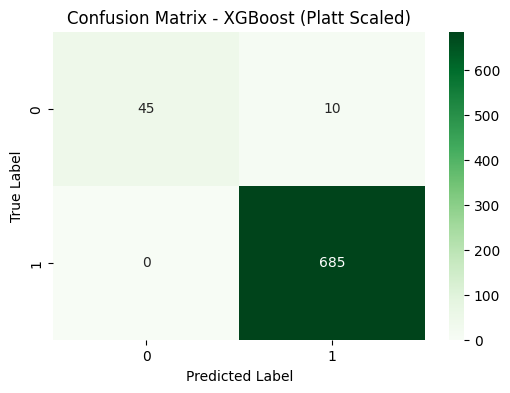


ROC AUC Score: 0.9870


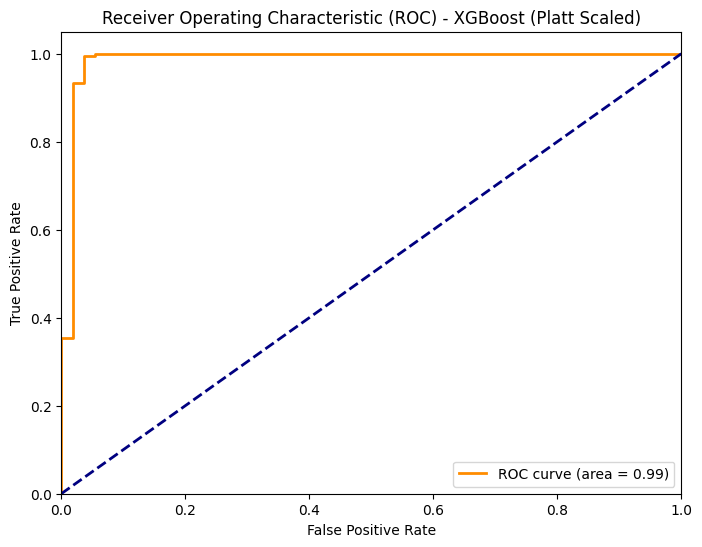

In [8]:
print("\n--- Evaluating Platt Scaled Model ---")
y_pred_platt_calibrated = calibrated_xgb_clf_sigmoid.predict(X_test_scaled)
utils.evaluate_model_performance(y_test, y_pred_platt_calibrated, X_test_scaled, calibrated_xgb_clf_sigmoid, "XGBoost (Platt Scaled)")


--- Evaluating Isotonic Regression Calibrated Model ---

--- XGBoost (Isotonic) Evaluation ---
Accuracy: 0.9919

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.89      0.94        55
 Class y (1)       0.99      1.00      1.00       685

    accuracy                           0.99       740
   macro avg       1.00      0.95      0.97       740
weighted avg       0.99      0.99      0.99       740


Confusion Matrix:
[[ 49   6]
 [  0 685]]


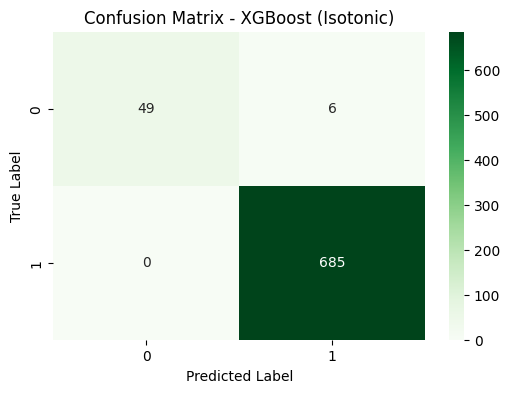


ROC AUC Score: 0.9874


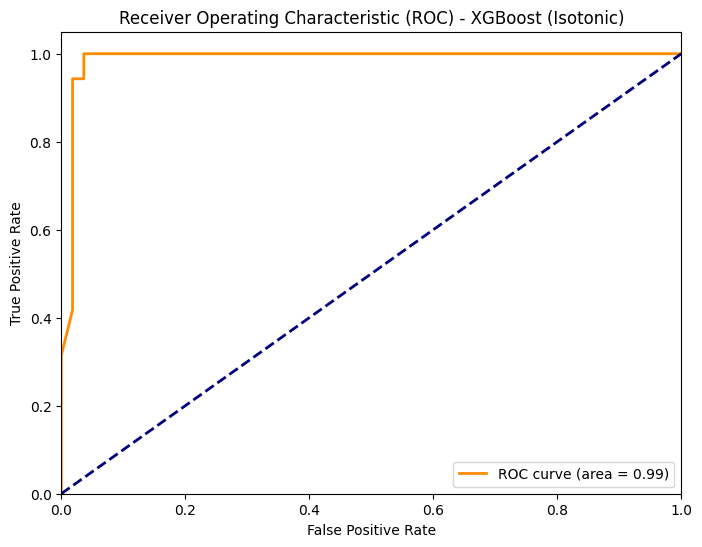

In [9]:
print("\n--- Evaluating Isotonic Regression Calibrated Model ---")
y_pred_isotonic_calibrated = calibrated_xgb_clf_isotonic.predict(X_test_scaled)
utils.evaluate_model_performance(y_test, y_pred_isotonic_calibrated, X_test_scaled, calibrated_xgb_clf_isotonic, "XGBoost (Isotonic)")

It seems we are getting the best results with the isotonic calibration. We will stay with that, since the model is close to perfection, but we will next run another cross-validation evaluation to validate that this was not a lucky punch.

### Cross-Validation of Isotonic Regression Calibrated Model


To get a more robust estimate of the Isotonic Regression calibrated model's performance and ensure the improvements are not due to a specific train-test split during the calibration phase, we perform an outer cross-validation on the entire `CalibratedClassifierCV` process. This involves fitting the `CalibratedClassifierCV` (which itself uses internal CV for calibration) on different folds of the training data.

In [10]:
# Define a fresh base XGBoost classifier for the CalibratedClassifierCV
# This is crucial because CalibratedClassifierCV will fit this estimator internally during its own CV process.
base_clf_for_cv_isotonic = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight_val
)

cv_calibrated_xgb_clf_isotonic = CalibratedClassifierCV(
    estimator=base_clf_for_cv_isotonic, 
    method='isotonic', 
    cv=5 # Internal CV for calibration. Could be different from outer CV folds.
)

print(f"Performing {n_splits_cv}-fold outer cross-validation on the Isotonic Calibrated model...")
print("(Note: CalibratedClassifierCV also performs internal CV for calibration on each outer fold)")


cv_results_isotonic_calibrated = {}
for metric_name, scorer in scoring_metrics.items():
    print("-" * 30)
    try:
        # We use strat_k_fold (defined earlier for uncalibrated model CV) for the outer cross-validation loop
        scores = cross_val_score(cv_calibrated_xgb_clf_isotonic, X_train_scaled, y_train, cv=strat_k_fold, scoring=scorer)
        cv_results_isotonic_calibrated[metric_name] = scores
        print(f"Outer CV {metric_name.upper()} scores (Isotonic Calibrated): {scores}")
        print(f"Mean Outer CV {metric_name.upper()} (Isotonic Calibrated): {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    except Exception as e:
        print(f"Could not calculate outer CV {metric_name.upper()} (Isotonic Calibrated). Error: {e}")

Performing 3-fold outer cross-validation on the Isotonic Calibrated model...
(Note: CalibratedClassifierCV also performs internal CV for calibration on each outer fold)
------------------------------
Outer CV ACCURACY scores (Isotonic Calibrated): [0.98784195 0.98378926 0.98580122]
Mean Outer CV ACCURACY (Isotonic Calibrated): 0.9858 (+/- 0.0017)
------------------------------
Outer CV ROC_AUC scores (Isotonic Calibrated): [0.97564459 0.96534294 0.96468814]
Mean Outer CV ROC_AUC (Isotonic Calibrated): 0.9686 (+/- 0.0050)
------------------------------
Outer CV F1 scores (Isotonic Calibrated): [0.98734525 0.9828772  0.98510227]
Mean Outer CV F1 (Isotonic Calibrated): 0.9851 (+/- 0.0018)


It seems that the std is pretty low indicating that the model is stable and is generalizing well. We will keep this model and the winner for now.

### Threshold Tuning for Isotonic Calibrated Model (Class n (0))


Since Isotonic calibration alters the model's probability outputs, it's beneficial to evaluate the optimal classification threshold for our specific needs (e.g., maximizing F1-score for Class 0) using these new, calibrated probabilities.

XGBoost is an algorithm that benefits from this since it is not really a probabilistic model and it tends to be biased to 0 or 1 probability, so actually applying the calibration normally gives a much clearer distinction in the range of probabilities to better adjust the threshold and ideal get better results.


--- Threshold Tuning for Class n (0) (Isotonic Calibrated Model) ---
Threshold  | Precision (0)   | Recall (0)   | F1-score (0) | TP (0)  | FP (0)  | FN (0) 
--------------------------------------------------------------------------------
0.05       | 1.0000          | 0.7091       | 0.8298       | 39      | 0       | 16     
0.10       | 1.0000          | 0.7273       | 0.8421       | 40      | 0       | 15     
0.15       | 1.0000          | 0.7273       | 0.8421       | 40      | 0       | 15     
0.20       | 1.0000          | 0.7636       | 0.8660       | 42      | 0       | 13     
0.25       | 1.0000          | 0.7636       | 0.8660       | 42      | 0       | 13     
0.30       | 1.0000          | 0.7636       | 0.8660       | 42      | 0       | 13     
0.35       | 1.0000          | 0.8000       | 0.8889       | 44      | 0       | 11     
0.40       | 1.0000          | 0.8364       | 0.9109       | 46      | 0       | 9      
0.45       | 1.0000          | 0.8364       | 0.

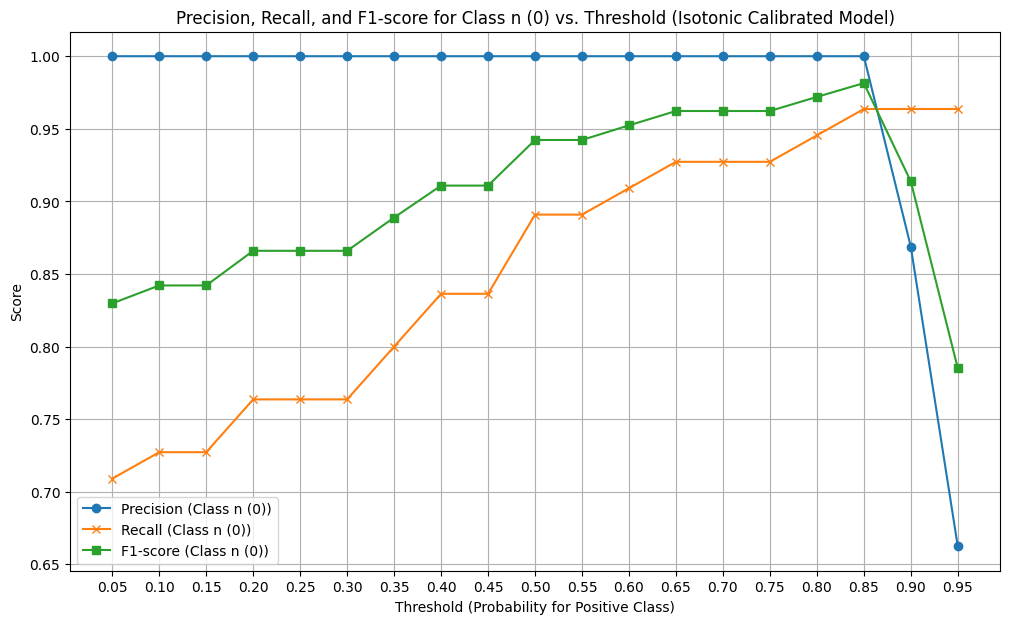


Optimal threshold for maximizing F1-score for Class n (0) (Isotonic Calibrated Model): 0.85
  Precision (Class 0) at this threshold: 1.0000
  Recall (Class 0) at this threshold: 0.9636
  F1-score (Class 0) at this threshold: 0.9815


In [11]:
# Get predicted probabilities for the positive class (Class 1, 'y') from the ISOTONIC CALIBRATED xgb_clf
# The calibrated_xgb_clf_isotonic model should already be fitted from the previous calibration cell.
y_pred_proba_isotonic_calibrated = calibrated_xgb_clf_isotonic.predict_proba(X_test_scaled)[:, 1]

# Define a range of threshold values to test
threshold_values = np.arange(0.05, 1.0, 0.05)

precisions_class0_isotonic = []
recalls_class0_isotonic = []
f1s_class0_isotonic = []


print("\n--- Threshold Tuning for Class n (0) (Isotonic Calibrated Model) ---")
print(f"{'Threshold':<10} | {'Precision (0)':<15} | {'Recall (0)':<12} | {'F1-score (0)':<12} | {'TP (0)':<7} | {'FP (0)':<7} | {'FN (0)':<7}")
print("-" * 80)


# threshold_values is already defined from the earlier threshold tuning section
for thresh_iso in threshold_values:
    # If prob_for_class_1 >= threshold, predict 1 (y), else 0 (n)
    y_pred_at_threshold_isotonic = (y_pred_proba_isotonic_calibrated >= thresh_iso).astype(int)
    
    # Calculate metrics for Class 0 (label 0)
    p_iso, r_iso, f_iso, s_iso = precision_recall_fscore_support(y_test, y_pred_at_threshold_isotonic, labels=[0, 1], zero_division=0)
    
    # Confusion matrix for this threshold to get TP, FP, FN for class 0
    cm_thresh_isotonic = confusion_matrix(y_test, y_pred_at_threshold_isotonic, labels=[0,1])
    tp_c0_iso = cm_thresh_isotonic[0,0] if cm_thresh_isotonic.shape == (2,2) else 0
    fp_c0_iso = cm_thresh_isotonic[1,0] if cm_thresh_isotonic.shape == (2,2) else 0 
    fn_c0_iso = cm_thresh_isotonic[0,1] if cm_thresh_isotonic.shape == (2,2) else 0

    precisions_class0_isotonic.append(p_iso[0])
    recalls_class0_isotonic.append(r_iso[0])
    f1s_class0_isotonic.append(f_iso[0])
    
    print(f"{thresh_iso:<10.2f} | {p_iso[0]:<15.4f} | {r_iso[0]:<12.4f} | {f_iso[0]:<12.4f} | {tp_c0_iso:<7} | {fp_c0_iso:<7} | {fn_c0_iso:<7}")


# Plotting the metrics for Isotonic Calibrated Model
utils.plot_threshold_tuning_curves(
    threshold_values, 
    {'precision': precisions_class0_isotonic, 'recall': recalls_class0_isotonic, 'f1': f1s_class0_isotonic}, 
    class_label_name="Class n (0)", 
    model_name_suffix="(Isotonic Calibrated Model)"
)


# Find threshold that maximizes F1-score for Class 0 for Isotonic Calibrated Model
if f1s_class0_isotonic and not all(v == 0 for v in f1s_class0_isotonic):
    optimal_idx_f1_class0_isotonic = np.argmax(f1s_class0_isotonic)
    optimal_threshold_f1_class0_isotonic = threshold_values[optimal_idx_f1_class0_isotonic]
    print(f"\nOptimal threshold for maximizing F1-score for Class n (0) (Isotonic Calibrated Model): {optimal_threshold_f1_class0_isotonic:.2f}")
    print(f"  Precision (Class 0) at this threshold: {precisions_class0_isotonic[optimal_idx_f1_class0_isotonic]:.4f}")
    print(f"  Recall (Class 0) at this threshold: {recalls_class0_isotonic[optimal_idx_f1_class0_isotonic]:.4f}")
    print(f"  F1-score (Class 0) at this threshold: {f1s_class0_isotonic[optimal_idx_f1_class0_isotonic]:.4f}")
else:
    print("\nCould not determine optimal threshold for F1-score (Class 0) (Isotonic Calibrated Model) as no valid F1 scores were calculated or all were zero.")


--- XGBoost (Isotonic Calibrated, Optimal Threshold for F1 Class 0: 0.85) Evaluation ---
Accuracy: 0.9973

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.96      0.98        55
 Class y (1)       1.00      1.00      1.00       685

    accuracy                           1.00       740
   macro avg       1.00      0.98      0.99       740
weighted avg       1.00      1.00      1.00       740


Confusion Matrix:
[[ 53   2]
 [  0 685]]


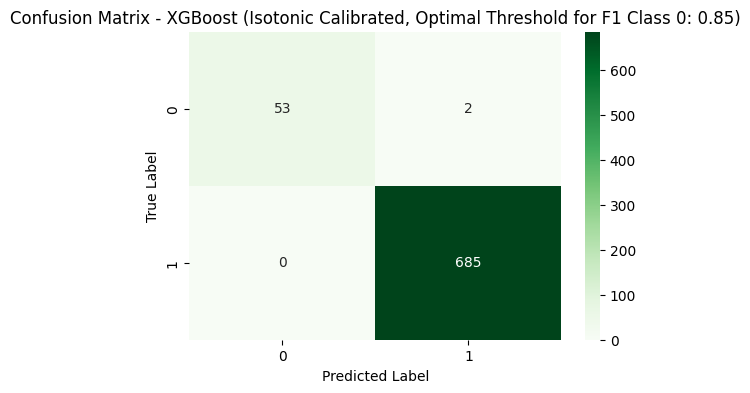


ROC AUC Score: 0.9874


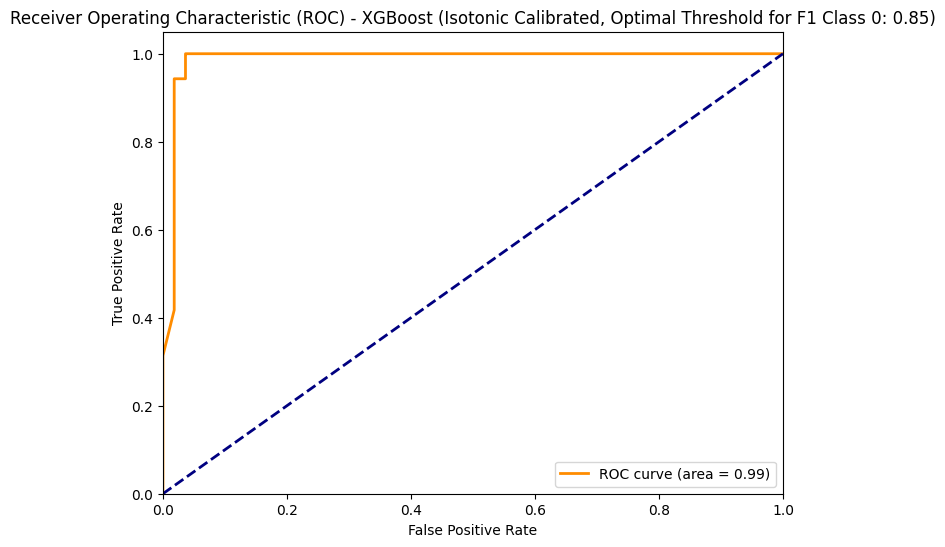

In [12]:

# Generate new binary predictions using the chosen optimal threshold:
y_pred_with_optimal_threshold = (y_pred_proba_isotonic_calibrated >= optimal_threshold_f1_class0_isotonic).astype(int)

# Evaluate the model's performance with these new, thresholded predictions.
utils.evaluate_model_performance(
    y_test,
    y_pred_with_optimal_threshold,
    X_test_scaled,  # Pass original features for predict_proba if needed by the function for ROC
    calibrated_xgb_clf_isotonic,  # The model that generated the probabilities
    f"XGBoost (Isotonic Calibrated, Optimal Threshold for F1 Class 0: {optimal_threshold_f1_class0_isotonic:.2f})"
)


We have confirmed the assumptions that adjusting the threshold is beneficial. So we keep this model with this threshold as our champ :)

## Export Model

Now let's export the model and create a small snippet to show how to load it for documentation and to make sure the export was successful.

In [13]:


# --- Export the Isotonic Calibrated Model and its Optimal Threshold ---

# Define file paths for the model and metadata
output_dir = "data"
model_filename = "calibrated_xgb_isotonic_model.joblib"
metadata_filename = "calibrated_xgb_isotonic_model_metadata.json"

model_filepath = os.path.join(output_dir, model_filename)
metadata_filepath = os.path.join(output_dir, metadata_filename)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Check if the model and threshold variables exist
print(f"\n--- Exporting Model and Optimal Threshold ---")

# 1. Save the calibrated XGBoost model
try:
    joblib.dump(calibrated_xgb_clf_isotonic, model_filepath)
    print(f"Isotonic calibrated XGBoost model saved to: {model_filepath}")
except Exception as e:
    print(f"Error saving model: {e}")
    # Optionally re-raise or handle

# 2. Save the model path and the optimal threshold to a metadata JSON file
model_metadata = {
    "model_filepath": model_filepath, # Storing relative path, assuming it's loaded from same context
    "optimal_threshold_f1_class0": optimal_threshold_f1_class0_isotonic,
    "calibration_method": "isotonic",
    "base_estimator": "XGBoost",
    "description": "Isotonic calibrated XGBoost model with optimal threshold for F1-score of Class 0 (negative class)."
}

try:
    with open(metadata_filepath, 'w') as f:
        json.dump(model_metadata, f, indent=4)
    print(f"Model metadata (including optimal threshold) saved to: {metadata_filepath}")
except Exception as e:
    print(f"Error saving metadata: {e}")
    # Optionally re-raise or handle
    


--- Exporting Model and Optimal Threshold ---
Isotonic calibrated XGBoost model saved to: data/calibrated_xgb_isotonic_model.joblib
Model metadata (including optimal threshold) saved to: data/calibrated_xgb_isotonic_model_metadata.json



--- XGBoost (Isotonic Calibrated, Optimal Threshold for F1 Class 0: 0.85) Evaluation ---
Accuracy: 0.9973

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.96      0.98        55
 Class y (1)       1.00      1.00      1.00       685

    accuracy                           1.00       740
   macro avg       1.00      0.98      0.99       740
weighted avg       1.00      1.00      1.00       740


Confusion Matrix:
[[ 53   2]
 [  0 685]]


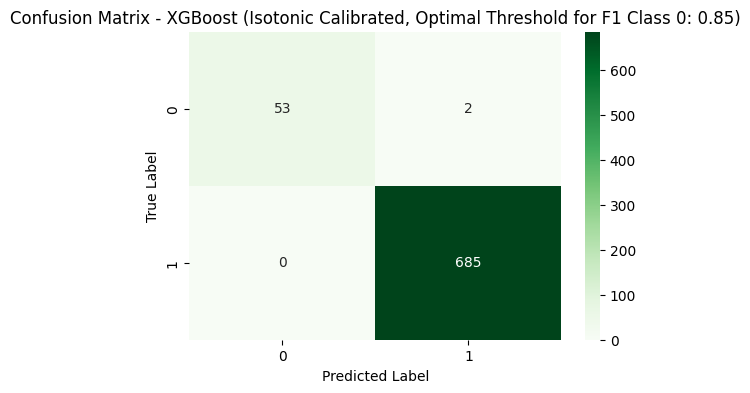


ROC AUC Score: 0.9874


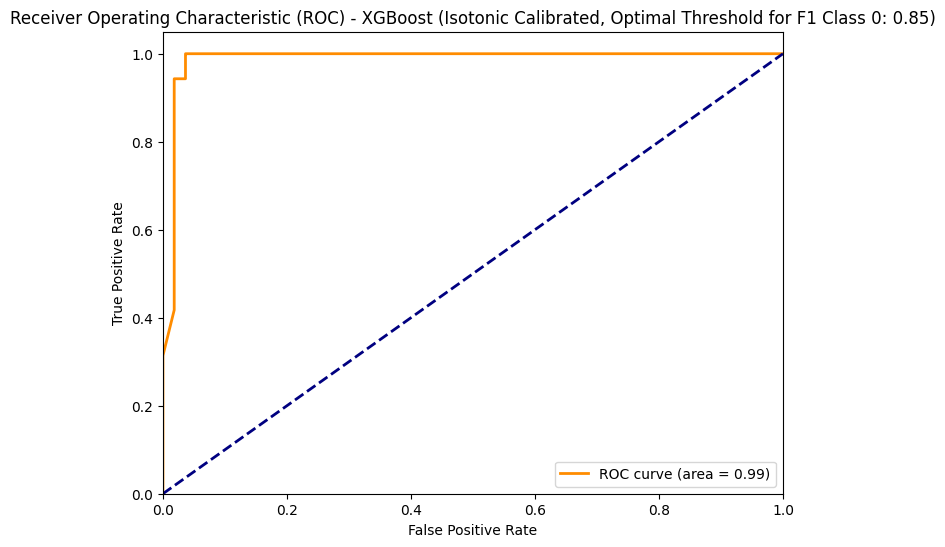

In [14]:

with open('data/calibrated_xgb_isotonic_model_metadata.json', 'r') as f:
    loaded_metadata = json.load(f)
    
loaded_model_path = loaded_metadata['model_filepath']
loaded_optimal_threshold = loaded_metadata['optimal_threshold_f1_class0']

loaded_calibrated_model = joblib.load(loaded_model_path)

y_new_proba = loaded_calibrated_model.predict_proba(X_test_scaled)[:, 1]
y_new_pred_with_optimal_threshold = (y_new_proba >= loaded_optimal_threshold).astype(int)

# Printing the metrics again to make sure that the model was correctly loaded
utils.evaluate_model_performance(
    y_test,
    y_new_pred_with_optimal_threshold,
    X_test_scaled,  # Pass original features for predict_proba if needed by the function for ROC
    loaded_calibrated_model,  # The model that generated the probabilities
    f"XGBoost (Isotonic Calibrated, Optimal Threshold for F1 Class 0: {optimal_threshold_f1_class0_isotonic:.2f})"
)
